In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import classyNN as cnn
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler

## Input

In [3]:
hlayers_sizes   = (400,400)
seed            = 1
verbose_train   = True
epochs          = 50
batch_size      = 128
std_scaler      = True
quantile_scaler = False
SNR_min         = 0 # used only in train-dataset

show_figs       = True
save_figs       = False

# for the LSO, 1.45 corresponds to a=0.99 in Kerr
#out_intervals   = np.array([[1,120], [0.8, 82], [-1, 1], [-1,1], [0.7, 75], [1, 100], [1.45,9], [0.05, 0.5]])

out_intervals = np.array([[1,120], [-1, 1], [-1,1], [0.85, 75]])

linear_output = False # if True, out_intervals is ignored. 
# Warning 1: using out_interval=None is not equivalnt to linear_output=True!!
# Warning 2: using linear_output=True can produce unphysical prediction!
# Memo: test 'compactification' on initial data

data_path = 'GstLAL/'
repo_path = '/home/simone/repos/IPAM2021_ML/'

## Start by loading the data. This should be exported in py-module

In [4]:
fname_train_data = data_path+'train_NS.csv'
fname_test_data  = data_path+'test_NS.csv'
train_datasets   = cnn.extract_data(fname_train_data, skip_header=True)
test_datasets    = cnn.extract_data(fname_test_data, skip_header=True)

In [5]:
# ID                0
# m1_inj            1
# m2_inj            2
# chi1_inj          3
# chi2_inj          4
# mc_inj            5
# q_inj             6
# R_isco_inj        7
# Compactness_inj   8
# m1_rec            9
# m2_rec           10
# chi1_rec         11
# chi2_rec         12
# mc_rec           13
# frac_mc_err      14
# q_rec            15
# R_isco_rec       16
# Compactness_rec  17
# snr              18
# s                19

def load_GstLAL_data(X, features='mass&spin'):
    """ Maybe a little bit pedantic, 
    but I prefer to keep this function as
    readable as possible 
    """
    if features=='all':
        m1_inj          = X[:, 1]
        m2_inj          = X[:, 2]
        chi1_inj        = X[:, 3]
        chi2_inj        = X[:, 4]
        mc_inj          = X[:, 5]
        q_inj           = X[:, 6]
        R_isco_inj      = X[:, 7]
        Compactness_inj = X[:, 8]
        m1_rec          = X[:, 9]
        m2_rec          = X[:,10]
        chi1_rec        = X[:,11]
        chi2_rec        = X[:,12]
        mc_rec          = X[:,13]
        q_rec           = X[:,15]
        R_isco_rec      = X[:,16]
        Compactness_rec = X[:,17]
        inj = np.column_stack((m1_inj,m2_inj,chi1_inj,chi2_inj,mc_inj,q_inj,R_isco_inj,Compactness_inj))
        rec = np.column_stack((m1_rec,m2_rec,chi1_rec,chi2_rec,mc_rec,q_rec,R_isco_rec,Compactness_rec))
        names = [r'$m_1$', r'$m_2$', r'$\chi_1$', r'$\chi_2$', r'${\cal M}_c$', r'$q$', \
                 r'$R_{\rm isco}$', r'$C$']
        
    elif features=='no_compactness':
        m1_inj          = X[:, 1]
        m2_inj          = X[:, 2]
        chi1_inj        = X[:, 3]
        chi2_inj        = X[:, 4]
        mc_inj          = X[:, 5]
        q_inj           = X[:, 6]
        R_isco_inj      = X[:, 7]
        m1_rec          = X[:, 9]
        m2_rec          = X[:,10]
        chi1_rec        = X[:,11]
        chi2_rec        = X[:,12]
        mc_rec          = X[:,13]
        q_rec           = X[:,15]
        R_isco_rec      = X[:,16]
        inj = np.column_stack((m1_inj,m2_inj,chi1_inj,chi2_inj,mc_inj,q_inj,R_isco_inj))
        rec = np.column_stack((m1_rec,m2_rec,chi1_rec,chi2_rec,mc_rec,q_rec,R_isco_rec))
        names = [r'$m_1$', r'$m_2$', r'$\chi_1$', r'$\chi_2$', r'${\cal M}_c$', r'$q$', \
                 r'$R_{\rm isco}$']
        
    elif features=='mass&spin':
        m1_inj          = X[:, 1]
        chi1_inj        = X[:, 3]
        chi2_inj        = X[:, 4]
        mc_inj          = X[:, 5]
        m1_rec          = X[:, 9]
        chi1_rec        = X[:,11]
        chi2_rec        = X[:,12]
        mc_rec          = X[:,13]
        inj = np.column_stack((m1_inj,chi1_inj,chi2_inj,mc_inj))
        rec = np.column_stack((m1_rec,chi1_rec,chi2_rec,mc_rec))
        names = [r'$m_1$', r'$\chi_1$', r'$\chi_2$', r'${\cal M}_c$']
        
    elif features=='spin':
        chi1_inj        = X[:, 3]
        chi2_inj        = X[:, 4]
        chi1_rec        = X[:,11]
        chi2_rec        = X[:,12]
        inj = np.column_stack((chi1_inj,chi2_inj))
        rec = np.column_stack((chi1_rec,chi2_rec))
        names = [r'$\chi_1$', r'$\chi_2$']
    ID  = X[:,0]
    snr = X[:,18]
    
    out          = {}
    out['inj']   = inj
    out['rec']   = rec
    out['SNR']   = snr
    out['names'] = names
    out['ID']    = ID
    return out

--------------------------------------------------
Nsamples (tot): 139999
--------------------------------------------------


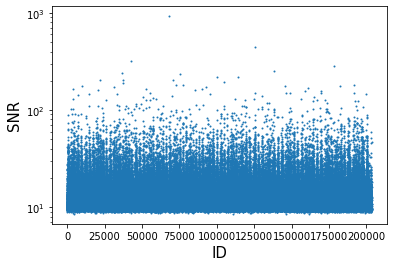

--------------------------------------------------  train  -------------------------------------------------


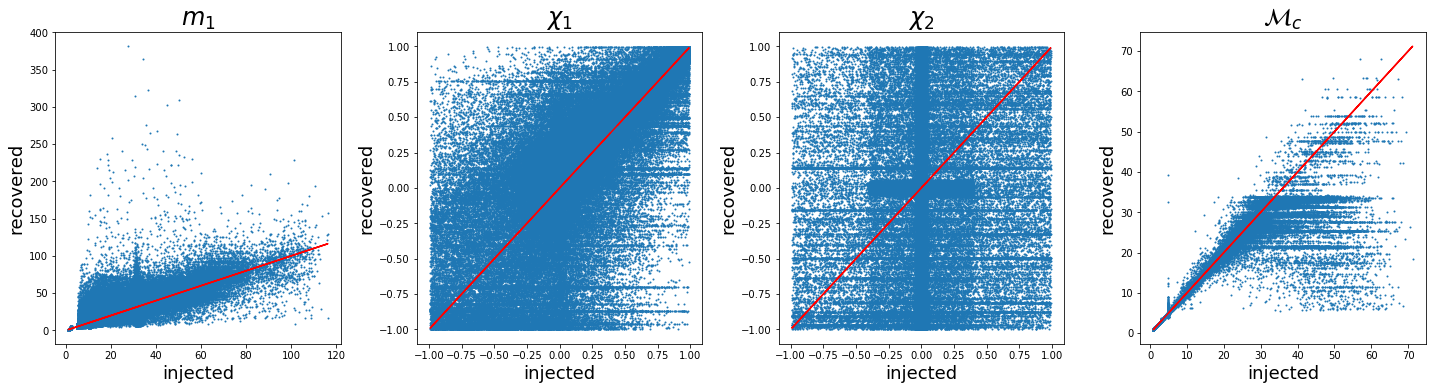

In [6]:
train_data_split = load_GstLAL_data(train_datasets, features='mass&spin')
train_inj = train_data_split['inj']
train_rec = train_data_split['rec']
train_snr = train_data_split['SNR']
train_ID  = train_data_split['ID']

print('-'*50)
print('Nsamples (tot):', len(train_snr))
print('-'*50)
if SNR_min>min(train_snr):
    rows2remove = []
    for i in range(len(train_snr)):
        snr = train_snr[i]
        if snr<SNR_min:
            rows2remove.append(i)
    train_inj = np.delete(train_inj, rows2remove, axis=0)
    train_rec = np.delete(train_rec, rows2remove, axis=0)
    train_snr = np.delete(train_snr, rows2remove, axis=0)
    train_ID  = np.delete(train_ID,  rows2remove, axis=0)
    print('SNR_min :', SNR_min)
    print('Nsamples:', len(train_snr))
    
test_data_split = load_GstLAL_data(test_datasets, features='mass&spin')
test_inj = test_data_split['inj']
test_rec = test_data_split['rec']
test_snr = test_data_split['SNR']

names     = train_data_split['names']
nfeatures = len(train_inj[0,:])
ntrain    = len(train_inj[:,0])
ntest     = len( test_inj[:,0])

plt.figure
plt.scatter(train_ID, train_snr, s=1)
plt.yscale('log')
plt.ylabel('SNR', fontsize=15)
plt.xlabel('ID', fontsize=15)
if save_figs:
    plt.savefig('snr.png',dpi=200,bbox_inches='tight')
if show_figs:
    plt.show()
else:
    plt.close()
    
print('-'*50,' train ','-'*49)
plt.figure(figsize=(20,10))
for i in range(nfeatures):
    ax = plt.subplot(241+i)
    ax.scatter(train_inj[:,i], train_rec[:,i],s=1)
    ax.plot(train_inj[:,i], train_inj[:,i], 'r')
    ax.set_title(names[i], fontsize=24)
    ax.set_xlabel('injected', fontsize=18)
    ax.set_ylabel('recovered', fontsize=18)
plt.tight_layout()
if save_figs:
    plt.savefig('rec_vs_inj.png',dpi=200,bbox_inches='tight')
if show_figs:
    plt.show()
else:
    plt.close()

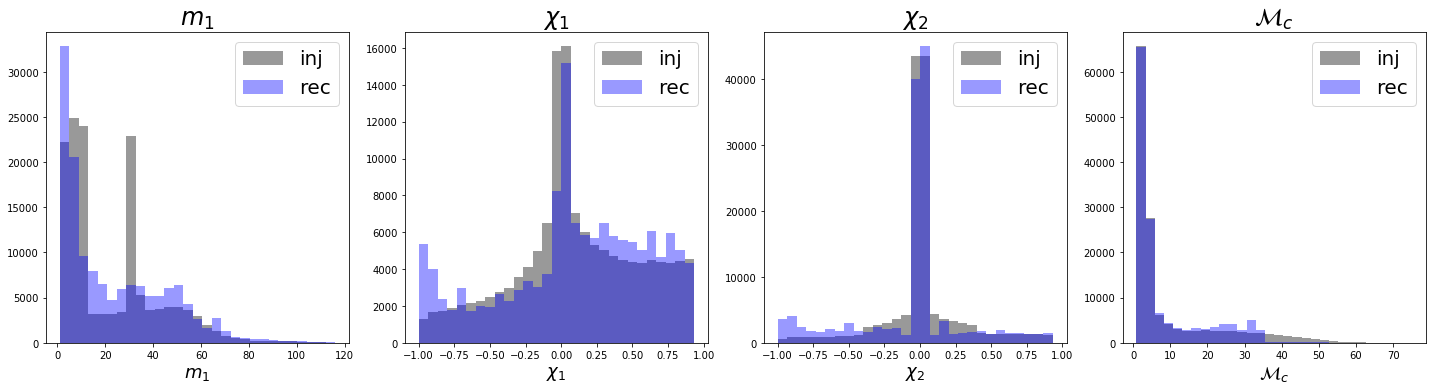

In [7]:
if out_intervals is not None:
    plt.figure(figsize=(20,10))
    nbins = 30
    for i in range(nfeatures):
        ax = plt.subplot(241+i)
        fmin  = out_intervals[i][0]
        fmax  = out_intervals[i][1]
        fstep = (fmax-fmin)/nbins
        ax.hist(train_inj[:,i], bins=np.arange(fmin, fmax, fstep), alpha=1,   color=[0.6,0.6,0.6], label='inj')
        ax.hist(train_rec[:,i], bins=np.arange(fmin, fmax, fstep), alpha=0.4, color=[0,0,1], label='rec')
        ax.set_title(names[i], fontsize=24)
        ax.set_xlabel(names[i], fontsize=18)
        ax.legend(fontsize=20)
    plt.tight_layout()
    if save_figs:
        plt.savefig('distr.png',dpi=200,bbox_inches='tight')
    if show_figs:
        plt.show()
    else:
        plt.close()

In [8]:
NN = cnn.RegressionNN(nfeatures=nfeatures, hlayers_sizes=hlayers_sizes, out_intervals=out_intervals, 
                      seed=seed, linear_output=linear_output)
NN.print_summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 400)               2000      
                                                                 
 dense_1 (Dense)             (None, 400)               160400    
                                                                 
 dense_2 (Dense)             (None, 4)                 1604      
                                                                 
Total params: 164,004
Trainable params: 164,004
Non-trainable params: 0
_________________________________________________________________


In [9]:
NN.load_train_dataset(xtrain_data=train_rec, ytrain_data=train_inj, 
                      verbose=False, quantile=quantile_scaler, standard_scaler=std_scaler)

In [10]:
"""
X0 = NN.xtrain_notnorm
Y  = NN.scaler_x.transform(X0)
X1 = NN.scaler_x.inverse_transform(Y)

for i in range(NN.nfeatures):
    print('-'*80, 'feature n.'+str(i+1), '-'*80, sep='\n')
    plt.figure(figsize=(13,5))
    plt.subplot(131)
    plt.scatter(NN.xtrain_notnorm[:,i], NN.ytrain_notnorm[:,i], s=1)
    plt.xlabel('x not rescaled', fontsize=15)
    plt.ylabel('y not rescaled', fontsize=15)
    plt.subplot(132)
    plt.scatter(NN.xtrain[:,i], NN.ytrain[:,i], s=1)
    plt.xlabel('x rescaled', fontsize=15)
    plt.ylabel('y rescaled', fontsize=15)
    nan_counter_Y  = 0
    nan_counter_X1 = 0
    for j in range(len(Y[:,i])):
        y  =  Y[j,i]
        x1 = X1[j,i]
        if np.isnan(y):
            nan_counter_Y += 1
        if np.isnan(x1):
            nan_counter_X1 += 1
    if nan_counter_Y == 0:
        plt.subplot(133)
        x = NN.xtrain[:,i]
        plt.hist(x, bins=np.linspace(min(x), max(x), 50), histtype='bar', ec='black')
        #plt.hist(Y[:,i], bins=np.linspace(min(x), max(x), 50), alpha=0.5, histtype='bar', ec='black')
        plt.xlabel('x rescaled - distribution', fontsize=15)
    plt.tight_layout()
    if save_figs:
        plt.savefig('scaler_feature'+str(i)+'.png',dpi=200,bbox_inches='tight')
    if show_figs:
        plt.show()
    else:
        plt.close()
    diff = X1[:,i]-X0[:,i]
    print('max diff check : ', max(diff))
    print('NaN found in Y : ', nan_counter_Y)
    print('NaN found in X1: ', nan_counter_X1, '\n\n\n')
""";

In [11]:
NN.training(epochs=epochs, batch_size=batch_size, verbose=verbose_train)

Epoch 1/50
1094/1094 [==============================] - 5s 4ms/step - loss: 0.0492 - mean_squared_error: 0.0492 - R2metric: 0.8246
Epoch 2/50
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0412 - mean_squared_error: 0.0412 - R2metric: 0.8532
Epoch 3/50
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0386 - mean_squared_error: 0.0386 - R2metric: 0.8624
Epoch 4/50
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0378 - mean_squared_error: 0.0378 - R2metric: 0.8656
Epoch 5/50
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0372 - mean_squared_error: 0.0372 - R2metric: 0.8674
Epoch 6/50
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0370 - mean_squared_error: 0.0370 - R2metric: 0.8682
Epoch 7/50
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0368 - mean_squared_error: 0.0368 - R2metric: 0.8689
Epoch 8/50
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0366 

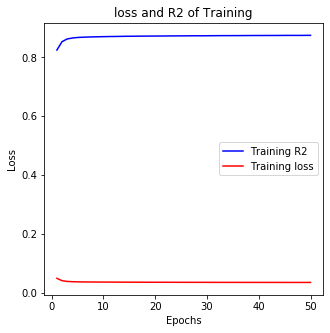

In [12]:
NN.plot_history(show=show_figs, save=save_figs)

In [13]:
NN.load_test_dataset(xtest_data=test_rec, ytest_data=test_inj, verbose=True)

In [14]:
print('-'*25, 'R2 for recovery', '-'*25)
def R2_numpy(y_true, y_pred):
            SS_res = np.sum((y_true - y_pred )**2)
            SS_tot = np.sum((y_true - np.mean(y_true))**2)
            return 1-SS_res/SS_tot
for i in range(nfeatures):
    R2 = R2_numpy(test_inj[:,i], test_rec[:,i])  
    print('R2[{:2d}]         : {:.5f}'.format(i,R2))

print('-'*25, 'R2 for prediction', '-'*23)
NN.print_metrics()

# memo: 'Final R2 mean' is not very precise, maybe 'total' would be better

"""
print('-'*25, 'R2 for prediction, check', '-'*23)
test_pred = NN.compute_prediction(NN.xtest, transform_output=True)
for i in range(nfeatures):
    R2 = R2_numpy(test_inj[:,i], test_pred[:,i])  
    print('R2[{:2d}]         : {:.5f}'.format(i,R2))
""";

------------------------- R2 for recovery -------------------------
R2[ 0]         : 0.61870
R2[ 1]         : 0.28814
R2[ 2]         : -1.56280
R2[ 3]         : 0.84706
------------------------- R2 for prediction -----------------------
Final R2 mean  : 0.68646
R2[ 0]         : 0.88488
R2[ 1]         : 0.74458
R2[ 2]         : 0.14840
R2[ 3]         : 0.96800


## Histograms

------------------------------------------------ m1 --------------------------------------------------
mean rec   rel diff  :  -0.17166 (std= 0.58254, | rel diff |= 0.34841)
mean pred  rel diff  :  -0.01400 (std= 0.35333, | rel diff |= 0.15947)


median rec   rel diff  :  -0.08910
median pred  rel diff  :   0.02938


recovery   below fmin= -4.00: 174
recovery   above fmax=  1.00: 0
prediction below fmin= -4.00: 56
prediction above fmax=  1.00: 0


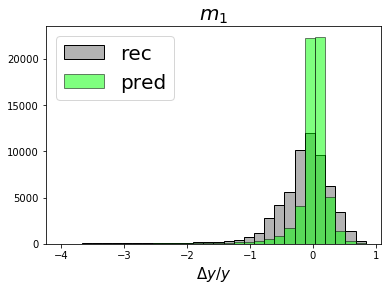

---------------------------------------------  chi1 --------------------------------------------------
mean rec  difference :  -0.00289 (std= 0.38856, |difference|= 0.26675)
mean pred difference :   0.00401 (std= 0.23272, |difference|= 0.13986)


median rec  difference :  -0.02098
median pred difference :   0.02037


recovery   below fmin= -1.70: 5
recovery   above fmax=  1.70: 28
prediction below fmin= -1.70: 0
prediction above fmax=  1.70: 0


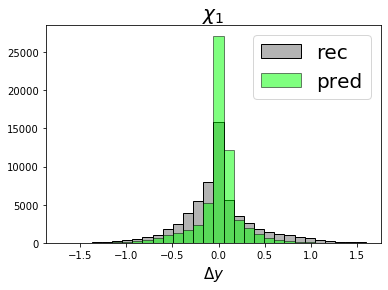

---------------------------------------------- chi2 --------------------------------------------------
mean rec  difference :   0.06589 (std= 0.45543, |difference|= 0.27354)
mean pred difference :  -0.00177 (std= 0.26526, |difference|= 0.14952)


median rec  difference :   0.00390
median pred difference :   0.00140


recovery   below fmin= -1.70: 43
recovery   above fmax=  1.70: 162
prediction below fmin= -1.70: 0
prediction above fmax=  1.70: 0


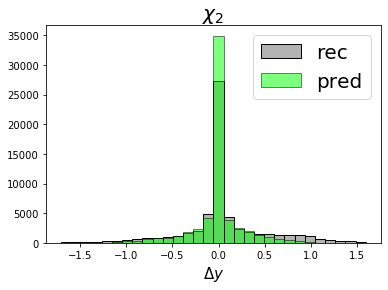

------------------------------------------------ Mc --------------------------------------------------
mean rec   rel diff  :   0.02365 (std= 0.11199, | rel diff |= 0.03979)
mean pred  rel diff  :  -0.02429 (std= 0.12412, | rel diff |= 0.07195)


median rec   rel diff  :  -0.00005
median pred  rel diff  :  -0.01041


recovery   below fmin= -1.50: 5
recovery   above fmax=  1.00: 0
prediction below fmin= -1.50: 29
prediction above fmax=  1.00: 0


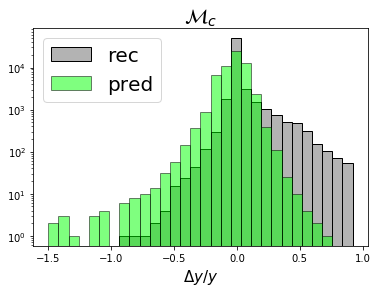

In [15]:
"""
nolatex_names = [ 'm1',   'm2', ' chi1',  'chi2',    'Mc',    'q',  'R_ISCO',     'C']
fmin_vec      = [   -4,     -3,    -1.7,    -1.7,    -1.5,     -4,      -1.7,    -0.5]
fmax_vec      = [    1,      1,     1.7,     1.7,     1.0,    1.2,       0.8,     0.5]
abs_diff_vec  = [False,  False,    True,    True,   False,  False,     False,    True]
logscale_vec  = [False,  False,   False,   False,    True,  False,     False,   False]
"""
nolatex_names = [ 'm1',   ' chi1',  'chi2',    'Mc']
fmin_vec      = [   -4,     -1.7,    -1.7,    -1.5 ]
fmax_vec      = [    1,      1.7,     1.7,     1.0 ]
abs_diff_vec  = [False,     True,    True,   False ]
logscale_vec  = [False,    False,   False,    True ]

for i in range(nfeatures):
    print('-'*(50-len(nolatex_names[i])), nolatex_names[i], '-'*50)
    NN.plot_err_histogram(feature_idx=i, fmin=fmin_vec[i], fmax=fmax_vec[i], verbose=True, 
                          abs_diff=abs_diff_vec[i], name=names[i], show=show_figs, save=save_figs, 
                          logscale=logscale_vec[i])

## Other plots 

In [16]:
import sys
sys.path.insert(0, repo_path+'utils')
import fancyplots
#import importlib
#importlib.reload(fancyplots)

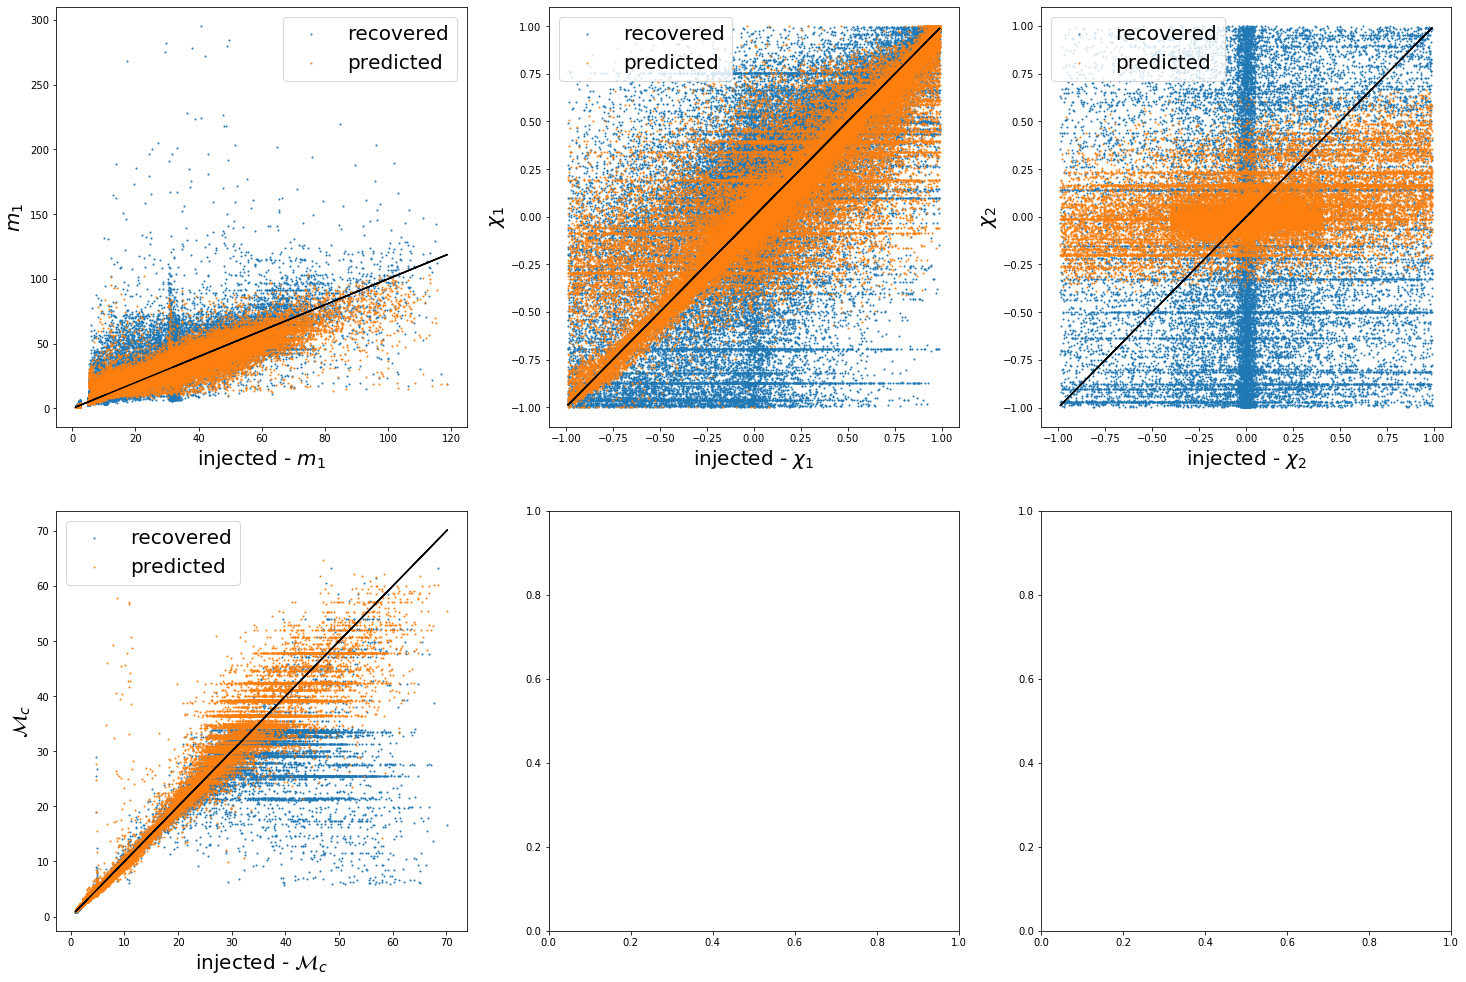

In [17]:
prediction = NN.compute_prediction(NN.xtest) # normalized prediction
fancyplots.checkRegressionPlot(NN.xtest, NN.ytest, prediction, names, 
                              scaler_y=NN.scaler_y, scaler_x=NN.scaler_x, show=show_figs, save=save_figs)

In [18]:
predicted = NN.compute_prediction(NN.xtest, transform_output=True)
injected  = NN.ytest_notnorm
recovered = NN.xtest_notnorm

In [19]:
if nfeatures==8:
    m1_pred = predicted[:,0]
    m2_pred = predicted[:,1]
    Mc_pred = predicted[:,4]

    m1_inj  = injected[:,0]
    m2_inj  = injected[:,1]
    Mc_inj  = injected[:,4]

    m1_rec  = recovered[:,0]
    m2_rec  = recovered[:,1]
    Mc_rec  = recovered[:,4]

    def compute_Mc(m1,m2):
        return (m1*m2)**(3/5)/(m1+m2)**(1/5)

    Mc_comp = compute_Mc(m1_pred, m2_pred)

    color_rec  = np.array([0.6,0.6,0.6])
    color_pred = np.array([0,1,0])
    color_comp = np.array([1,0,0])

    plt.figure
    plt.scatter(Mc_inj, Mc_rec , s=1, c=color_rec.reshape(1,-1))
    plt.scatter(Mc_inj, Mc_pred, s=1, c=color_pred.reshape(1,-1))
    plt.scatter(Mc_inj, Mc_comp, s=1, c=color_comp.reshape(1,-1))
    plt.plot(Mc_inj, Mc_inj, c=[0,0,0])
    plt.xlabel(r'$M_c$ - inj', fontsize=15)
    plt.ylabel(r'$M_c$', fontsize=15)
    if save_figs:
        plt.savefig('Mc.png',dpi=200,bbox_inches='tight')
    if show_figs:
        plt.show()
    else:
        plt.close()

    nbins = 31

    errors_rec  = (Mc_inj- Mc_rec )/Mc_inj
    errors_pred = (Mc_inj- Mc_pred)/Mc_inj
    errors_comp = (Mc_inj- Mc_comp)/Mc_inj

    fmin  = -3
    fmax  =  3
    fstep = (fmax-fmin)/nbins

    pred_min_outliers = 0 
    pred_max_outliers = 0 
    for i in range(len(errors_pred)):
        if errors_pred[i]<fmin:
            pred_min_outliers += 1
    for i in range(len(errors_pred)):
        if errors_pred[i]>fmax:
            pred_max_outliers += 1 
    rec_min_outliers = 0 
    rec_max_outliers = 0 
    for i in range(len(errors_rec)):
        if errors_rec[i]<fmin:
            rec_min_outliers += 1
    for i in range(len(errors_rec)):
        if errors_rec[i]>fmax:
            rec_max_outliers += 1 
    comp_min_outliers = 0 
    comp_max_outliers = 0 
    for i in range(len(errors_comp)):
        if errors_comp[i]<fmin:
            comp_min_outliers += 1
    for i in range(len(errors_comp)):
        if errors_comp[i]>fmax:
            comp_max_outliers += 1 

    print('recovery    below fmin={:6.2f}: {:d}'.format(fmin,  rec_min_outliers))
    print('recovery    above fmax={:6.2f}: {:d}'.format(fmax,  rec_max_outliers))
    print('prediction  below fmin={:6.2f}: {:d}'.format(fmin, pred_min_outliers))
    print('prediction  above fmax={:6.2f}: {:d}'.format(fmax, pred_max_outliers))
    print('computation below fmin={:6.2f}: {:d}'.format(fmin, comp_min_outliers))
    print('computation above fmax={:6.2f}: {:d}'.format(fmax, comp_max_outliers))

    plt.figure
    plt.hist(errors_rec , bins=np.arange(fmin, fmax, fstep), alpha=1.0, color=color_rec,  label='rec',
             histtype='bar', ec='black')
    plt.hist(errors_pred, bins=np.arange(fmin, fmax, fstep), alpha=0.7, color=color_pred, label='pred',
             histtype='bar', ec='black')
    plt.hist(errors_comp, bins=np.arange(fmin, fmax, fstep), alpha=0.5, color=color_comp, label='comp',
             histtype='bar', ec='black')
    plt.legend(fontsize=20)
    plt.xlabel(r'$\Delta y/y$', fontsize=15)
    if save_figs:
        plt.savefig('err_hist_Mc.png',dpi=200,bbox_inches='tight')
    if show_figs:
        plt.show()
    else:
        plt.close()

In [20]:
def Test(x, y, plot=True, bins_plot=False, sigma_tol=10, n=1000, alpha=1, project=False, plot_xbins=False,
        print_ybins_info=False):
    
    bins_hist = 30
    
    # sort according to x
    xs, ys = zip(*sorted(zip(x, y)))
    xs = np.array(xs)
    ys = np.array(ys)
    
    # divide in bins
    xbins = []
    ybins = []
    mean  = []
    xmin  = []
    xmax  = []
    xmid  = []
    std   = []
    skew  = []
    kurt  = []
    Nvec  = []
    Nxs = len(xs)
    nbins_guess = int(np.ceil(Nxs/n))
    # intervals
    interv_edges = []
    idx = 0
    i = 0
    while idx<Nxs:
        idx = round((i*n)**(alpha)/alpha)
        if idx>Nxs-1:
            interv_edges.append(Nxs-1)
            break
        else:
            interv_edges.append(idx)
        i += 1
    
    nbins_guess = len(interv_edges)-1
    for i in range(nbins_guess):
        new_xbin  = np.array(xs[interv_edges[i] : interv_edges[i+1]])
        new_ybin  = np.array(ys[interv_edges[i] : interv_edges[i+1]])
        new_xmin  = min(new_xbin)
        new_xmax  = max(new_xbin)
        new_xmid  = (new_xmax+new_xmin)/2
        new_mean = np.mean(new_ybin)
        
        if project:
            new_ybin = new_ybin + new_xmid - new_xbin
            new_xbin = new_xmid+new_xbin*0
        
        std_tmp = np.std(new_ybin)
        in3sigma = np.argwhere(new_ybin <= new_mean-sigma_tol*std_tmp)
        new_ybin = np.delete(new_ybin, in3sigma)
        new_xbin = np.delete(new_xbin, in3sigma)
        
        in3sigma = np.argwhere(new_ybin >= new_mean+sigma_tol*std_tmp)
        new_ybin = np.delete(new_ybin, in3sigma)
        new_xbin = np.delete(new_xbin, in3sigma)

        new_xmin  = min(new_xbin)
        new_xmax  = max(new_xbin)
        new_xmid  = (new_xmax+new_xmin)/2
        new_mean = np.mean(new_ybin)
        
        if i>0 and np.abs(new_xmid-xmid[-1])<1e-4:  
            old_xbin = xbins[-1]
            old_ybin = ybins[-1]
            new_xbin = np.concatenate((old_xbin, new_xbin), axis=0)
            new_ybin = np.concatenate((old_ybin, new_ybin), axis=0)
            new_xmin = min(new_xbin)
            new_xmax = max(new_xbin)
            new_xmid = (new_xmax+new_xmin)/2
            new_mean = np.mean(new_ybin)

            xbins[-1] = new_xbin
            ybins[-1] = new_ybin
            mean[-1]  = new_mean
            xmin[-1]  = new_xmin
            xmax[-1]  = new_xmax
            xmid[-1]  = new_xmid
            Nvec[-1]  = len(new_xbin)
            std[-1]   = np.std(new_ybin)
            skew[-1]  = stats.skew(new_ybin)
            kurt[-1]  = stats.kurtosis(new_ybin)
        else:
            xbins.append(new_xbin)
            ybins.append(new_ybin)
            mean.append(new_mean)
            xmin.append(new_xmin)
            xmax.append(new_xmax)
            xmid.append(new_xmid)
            Nvec.append(len(new_xbin))
            std.append(np.std(new_ybin))
            skew.append(stats.skew(new_ybin))
            kurt.append(stats.kurtosis(new_ybin))
       
    nbins = len(xmid)
    std   = np.array(std)
    skew  = np.array(skew)
    kurt  = np.array(kurt)
    xmin  = np.array(xmin)
    xmax  = np.array(xmax)
    xmid  = np.array(xmid)
    mean  = np.array(mean)
    if plot:
        if np.all(xs>0):
            ncols = 3
            plt.figure(figsize=(12, 4))
        else:
            ncols = 2
            plt.figure(figsize=(7, 3))
        
        ax1 = plt.subplot(1,ncols,1)
        ax1.plot(xmid, xmax-xmin)
        ax1.set_xlabel(r'$\bar{x}$' , fontsize=18)
        ax1.set_ylabel(r'$\Delta x$', fontsize=18)
        ax1.set_yscale('log')
        ax1.grid(visible=True)
        
        ax2 = plt.subplot(1,ncols,2)
        for i in range(nbins):
            ax2.scatter(xbins[i], ybins[i], s=1)
        ax2.plot(xmid, mean, '-ko')
        ax2.plot(xmid, mean - std, c=[1,0,0])
        ax2.plot(xmid, mean + std, c=[1,0,0])
        ax2.set_xlabel('guess', fontsize=15)
        ax2.set_ylabel('true', fontsize=15)

        if np.all(xs>0):
            ax3 = plt.subplot(1,ncols,3)
            for i in range(nbins):
                ax3.scatter(xbins[i], ybins[i], s=1)
            ax3.plot(xmid, mean, '-ko')
            ax3.plot(xmid, mean - std, c=[1,0,0])
            ax3.plot(xmid, mean + std, c=[1,0,0])
            ax3.set_yscale('log')
            ax3.set_xscale('log')
            ax3.grid(visible=True)
            ax3.set_xlabel('guess', fontsize=15)
            ax3.set_ylabel('true', fontsize=15)
            
        plt.tight_layout()
        plt.show()
        
        plt.figure
        plt.plot(xmid, skew, 'r', label='skew')
        #plt.plot(xmid, kurt, 'b', label='kurt')
        plt.xlabel(r'$\bar{x}$', fontsize=15)
        plt.ylabel(r'$\gamma$', fontsize=15)
        plt.legend()
        plt.show()
        
    if bins_plot:
        i = 0
        subplot_cols = 8
        while i<len(ybins):
            j = 0
            if plot_xbins:
                plt.figure(figsize=(3*subplot_cols, 6))
            elif print_ybins_info:
                plt.figure(figsize=(3*subplot_cols, 4.5))
            else:
                plt.figure(figsize=(3*subplot_cols, 3))
            for j in range(subplot_cols):
                if i<len(ybins):
                    fmin = min(ybins[i])-mean[i]
                    fmax = max(ybins[i])-mean[i]
                    fstep = (fmax-fmin)/bins_hist
                    if plot_xbins:
                        ax1 = plt.subplot(2,subplot_cols,j+1)
                    else:
                        ax1 = plt.subplot(1,subplot_cols,j+1)
                    ax1.hist(ybins[i]-mean[i], bins=bins_hist, range=(fmin,fmax), ec='black')
                    if print_ybins_info:
                        ax1.set_title(r"$N$: {:d}".format(Nvec[i])           + "\n" +
                                      r"$x \in ({:.2f},{:.2f})$".format(xmin[i], xmax[i]) + "\n" +
                                      r"$\bar{{x}}$: {:.2f}".format(xmid[i])  + "\n" +
                                      r"$\hat{{y}}$: {:.2f}".format(mean[i]) + "\n" + 
                                      r"$\sigma_{{y}}$: {:.3f}".format(std[i]), fontsize=21)
                    if j==0:
                        ax1.set_ylabel('y', fontsize=20)
                    if plot_xbins:
                        ax2 = plt.subplot(2,subplot_cols,subplot_cols+j+1)
                        ax2.hist(xbins[i], bins=bins_hist, ec='black', color=[1,0.5,0])
                        if j==0:
                            ax2.set_ylabel('x', fontsize=20)
                else:
                    if plot_xbins:
                        ax1 = plt.subplot(2,subplot_cols,j+1)
                        ax2 = plt.subplot(2,subplot_cols,subplot_cols+j+1)
                    else:
                        ax1 = plt.subplot(1,subplot_cols,j+1)
                i += 1
                j += 1
            plt.tight_layout()
            plt.show()
            print('-'*114)
            
    return xbins, ybins

In [21]:
# Note that it is on train! We need the training-prediction to compute the error-statistic (I think)
predicted = NN.compute_prediction(NN.xtrain, transform_output=True)
injected  = NN.ytrain_notnorm
recovered = NN.xtrain_notnorm


################################################################################
feature n.4: {\cal M}_c
################################################################################


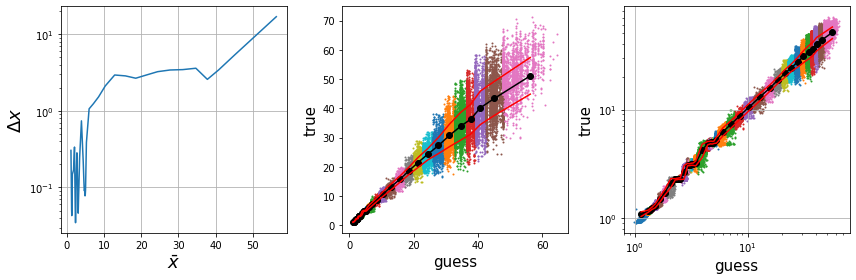

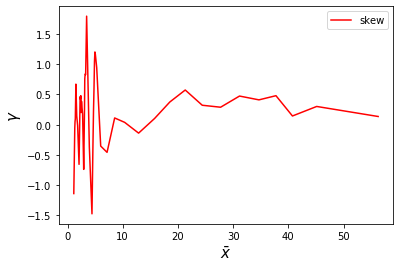

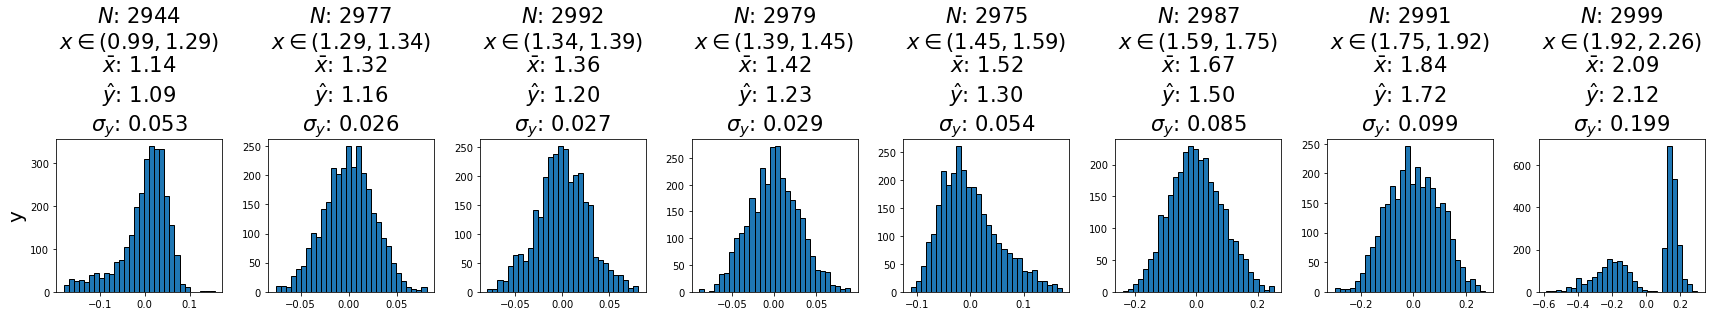

------------------------------------------------------------------------------------------------------------------


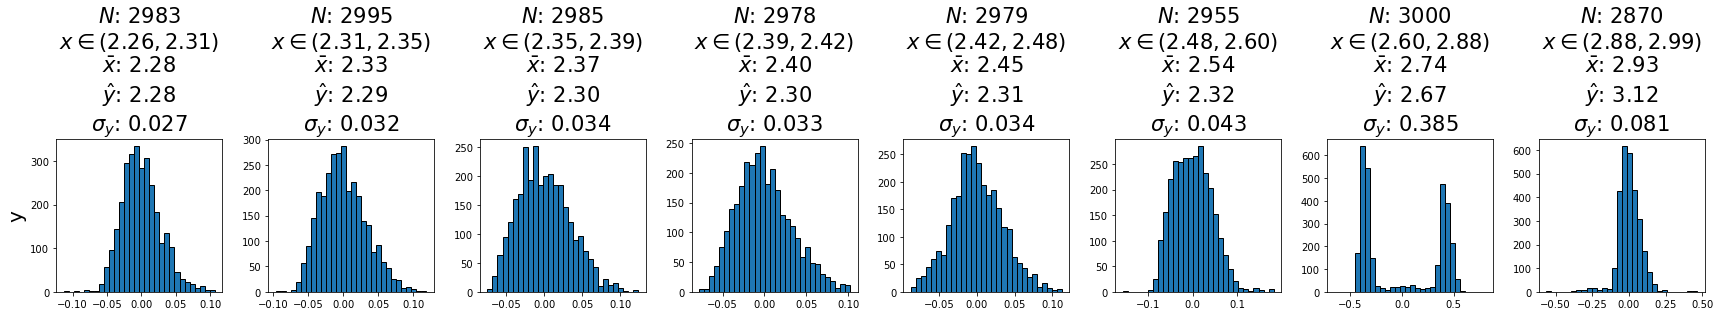

------------------------------------------------------------------------------------------------------------------


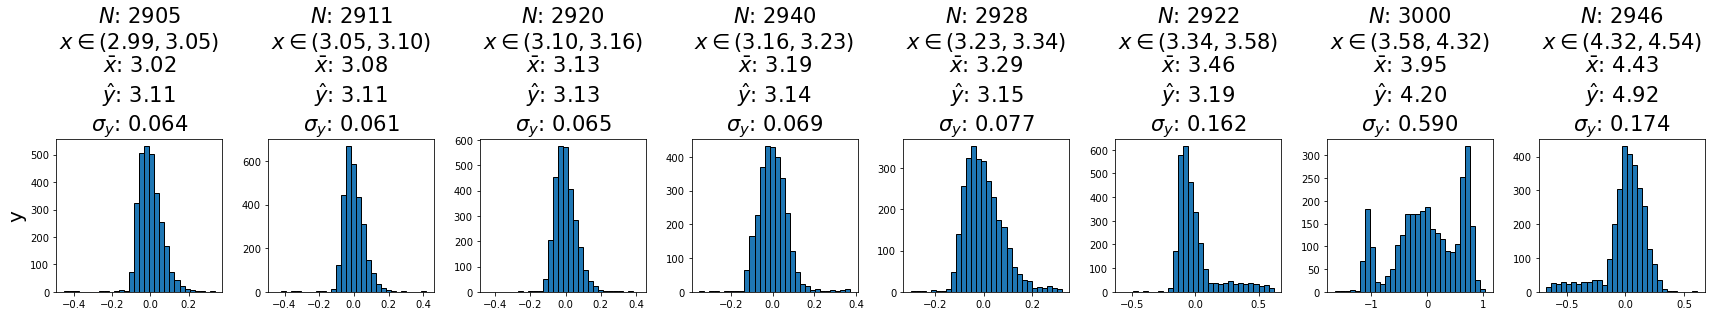

------------------------------------------------------------------------------------------------------------------


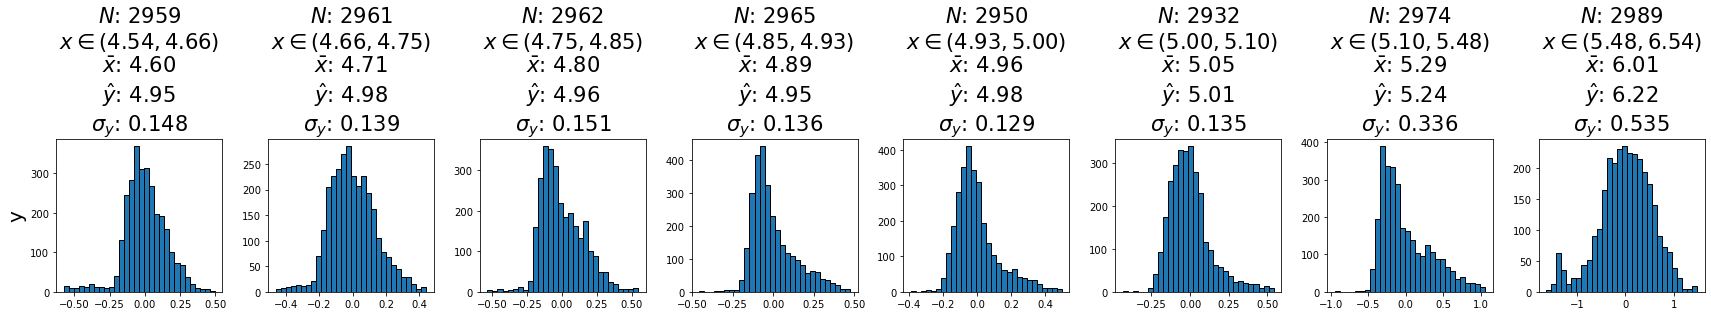

------------------------------------------------------------------------------------------------------------------


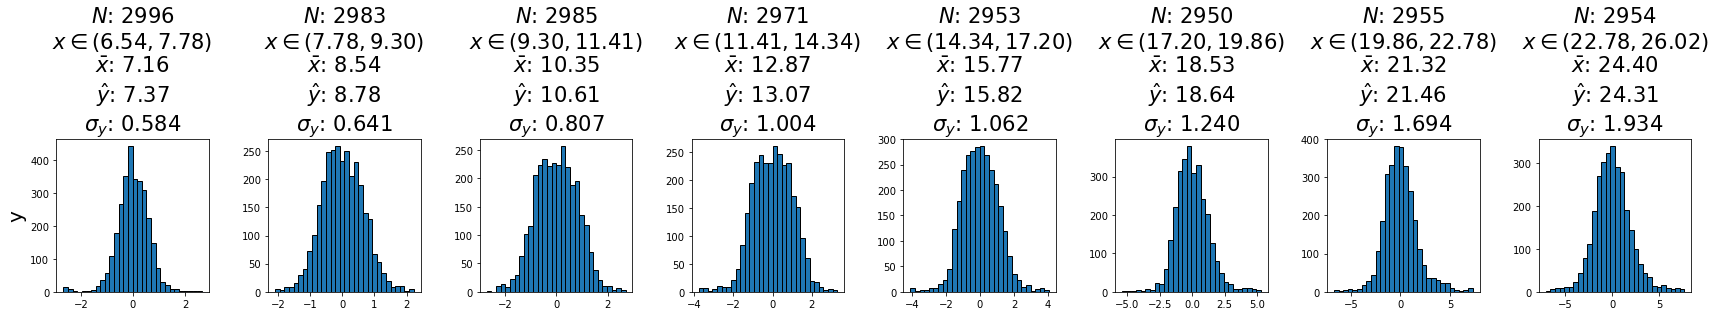

------------------------------------------------------------------------------------------------------------------


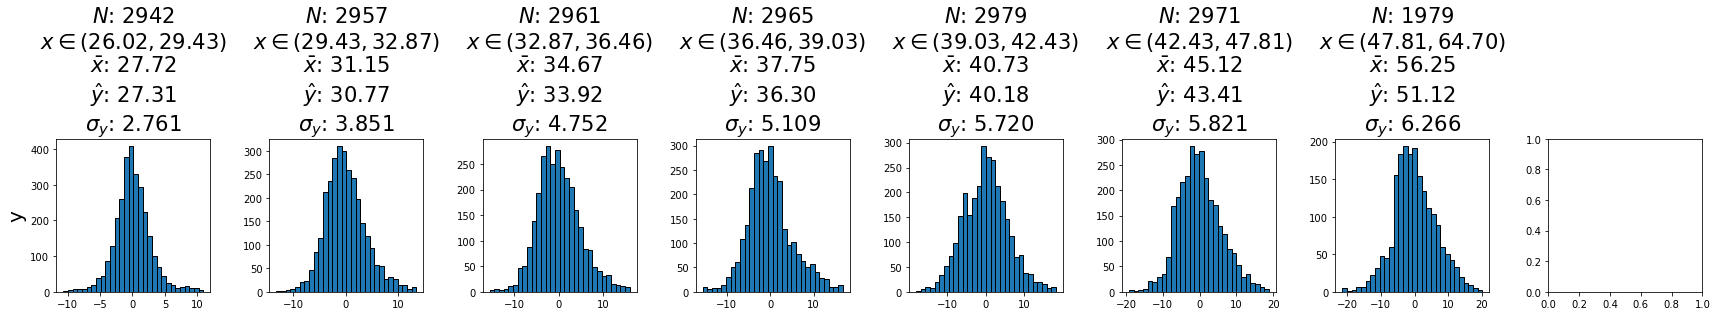

------------------------------------------------------------------------------------------------------------------


In [22]:
idx = 3
#x = recovered[:,idx]
x = predicted[:,idx]
y =  injected[:,idx]

print('\n', '#'*80,'\n', 'feature n.', idx+1, ': ', names[idx].replace('$', ''), '\n', '#'*80, sep='')
xbins, ybins = Test(x,y, plot=True, bins_plot=True, sigma_tol=3, n=3000, project=False, print_ybins_info=True)


################################################################################
feature n.4: {\cal M}_c
################################################################################


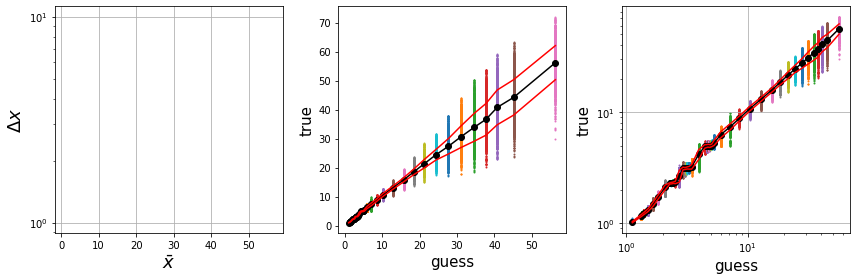

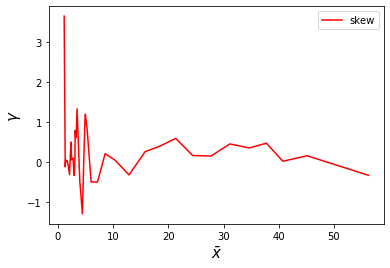

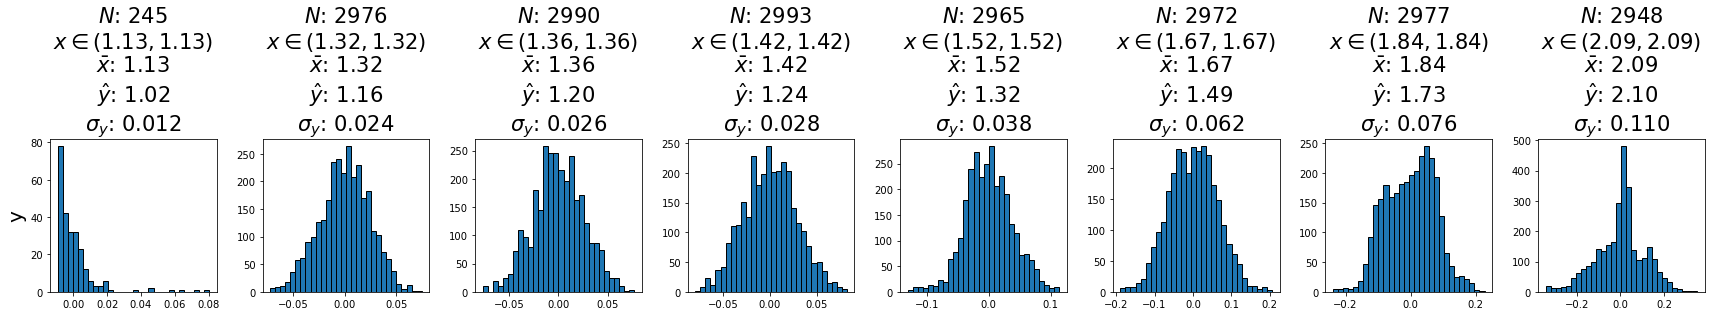

------------------------------------------------------------------------------------------------------------------


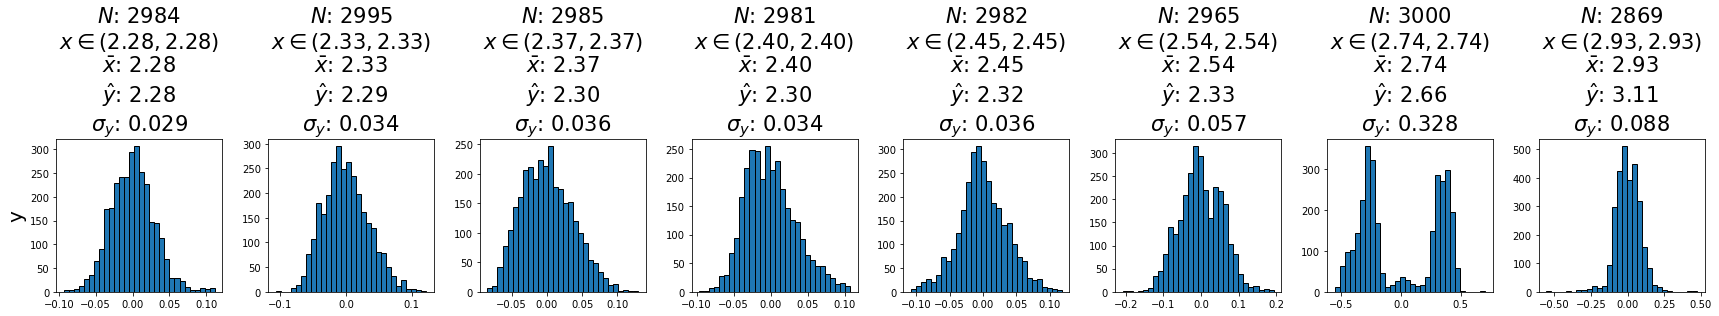

------------------------------------------------------------------------------------------------------------------


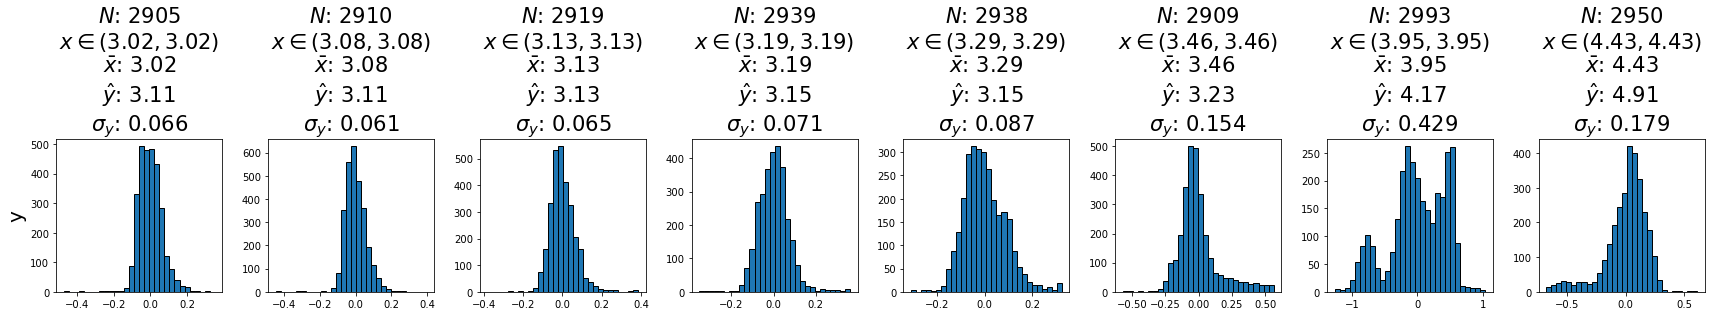

------------------------------------------------------------------------------------------------------------------


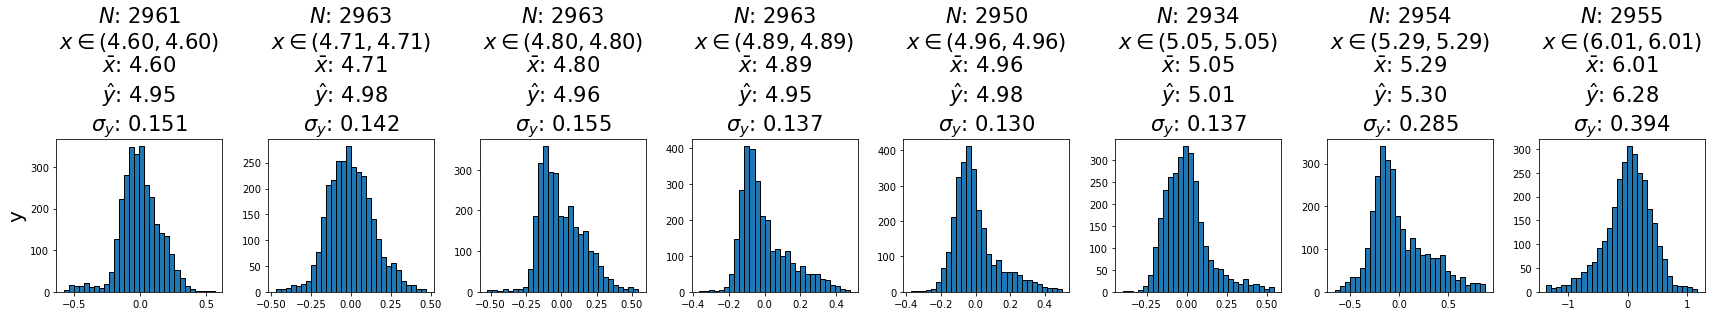

------------------------------------------------------------------------------------------------------------------


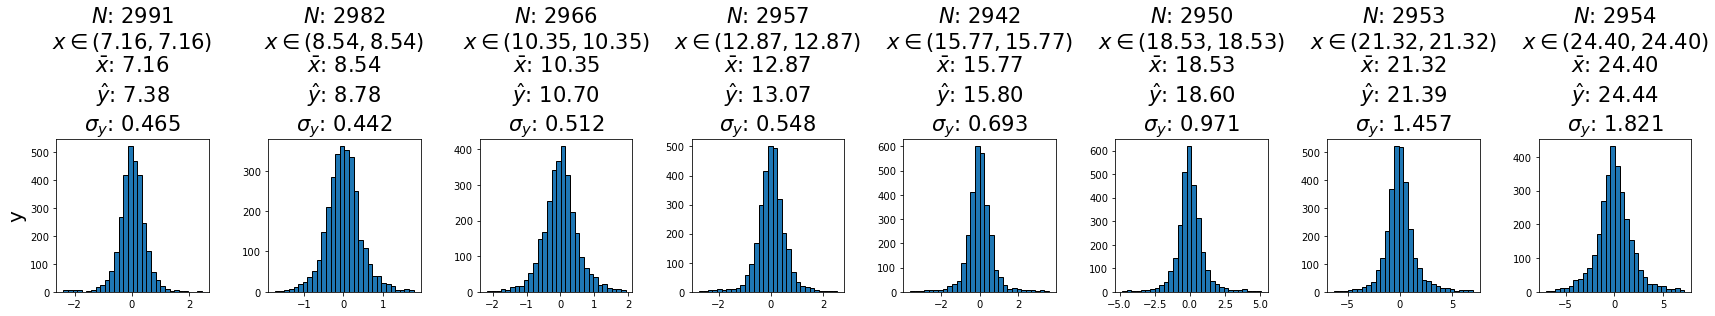

------------------------------------------------------------------------------------------------------------------


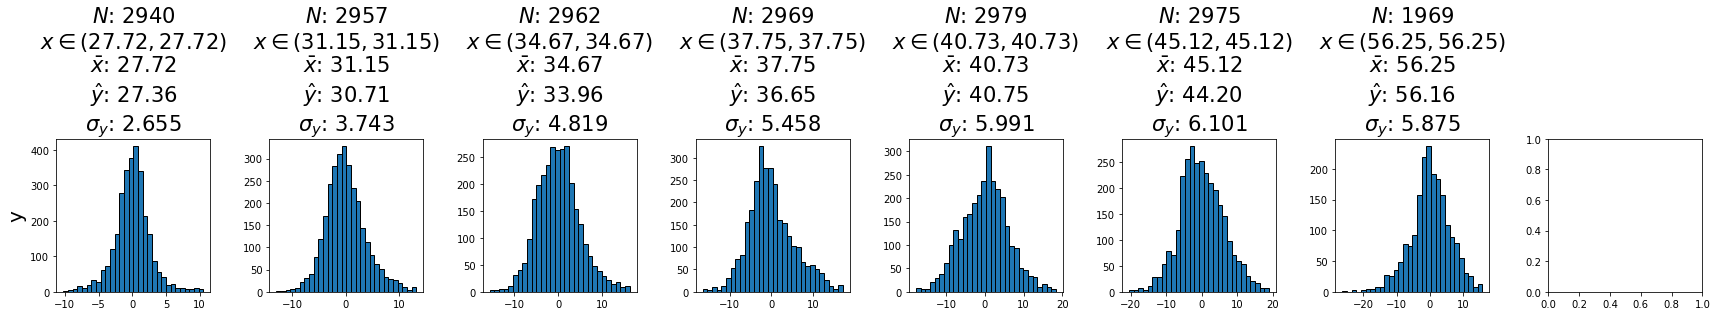

------------------------------------------------------------------------------------------------------------------


In [23]:
print('\n', '#'*80,'\n', 'feature n.', idx+1, ': ', names[idx].replace('$', ''), '\n', '#'*80, sep='')
xbins, ybins = Test(x,y, plot=True, bins_plot=True, sigma_tol=3, n=3000, project=True, print_ybins_info=True)


################################################################################
feature n.3: \chi_2
################################################################################


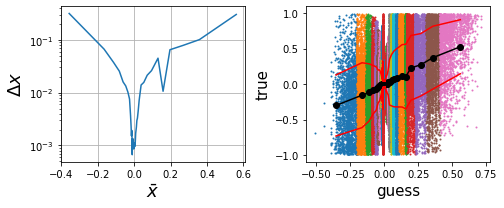

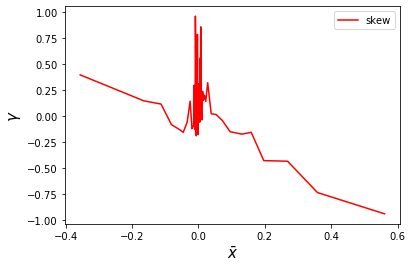

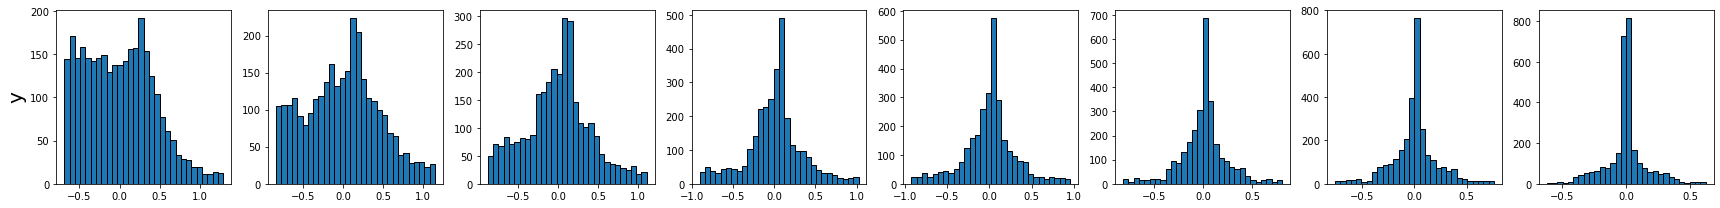

------------------------------------------------------------------------------------------------------------------


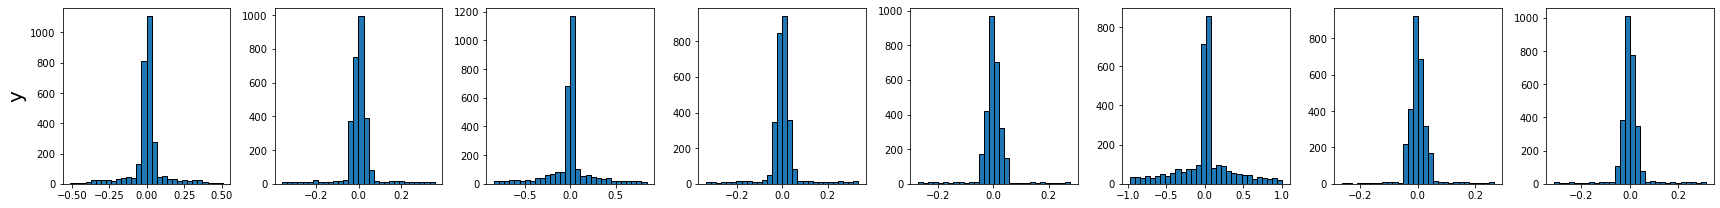

------------------------------------------------------------------------------------------------------------------


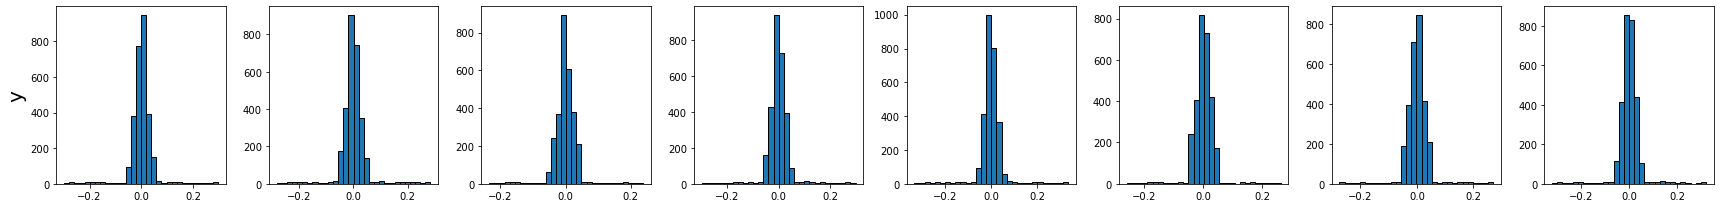

------------------------------------------------------------------------------------------------------------------


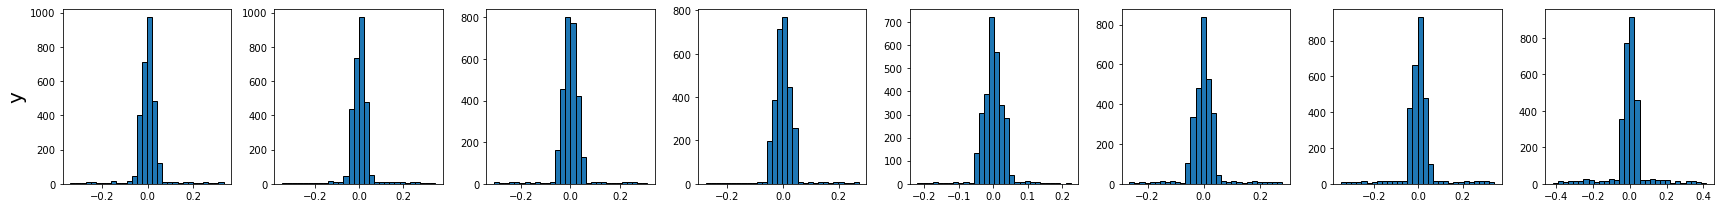

------------------------------------------------------------------------------------------------------------------


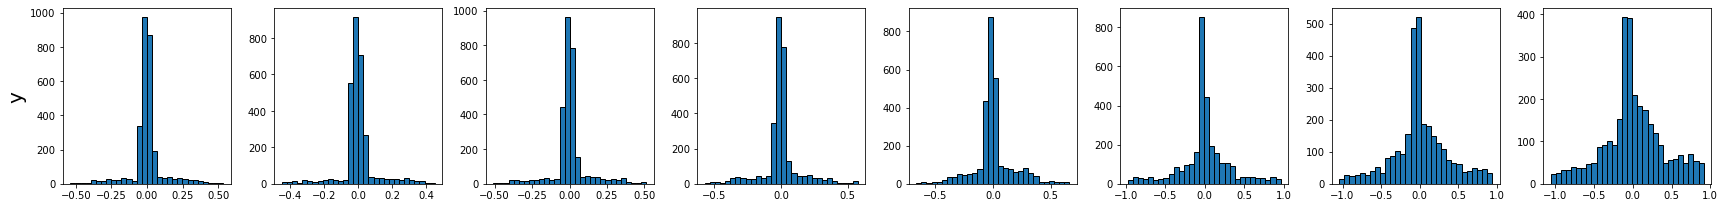

------------------------------------------------------------------------------------------------------------------


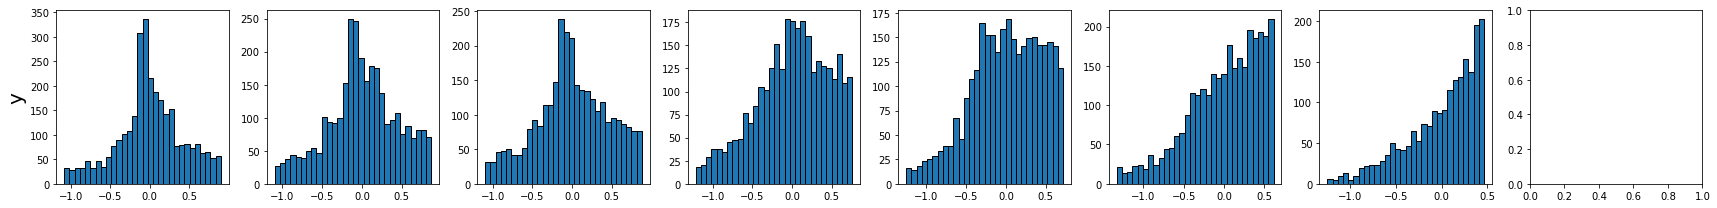

------------------------------------------------------------------------------------------------------------------


In [24]:
idx = 2
x = predicted[:,idx]
y =  injected[:,idx]
print('\n', '#'*80,'\n', 'feature n.', idx+1, ': ', names[idx].replace('$', ''), '\n', '#'*80, sep='')
xbins, ybins = Test(x,y, plot=True, bins_plot=True, sigma_tol=3, n=3000, project=False)


################################################################################
feature n.3: \chi_2
################################################################################


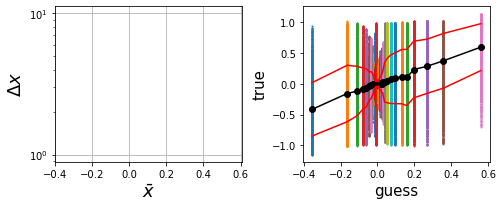

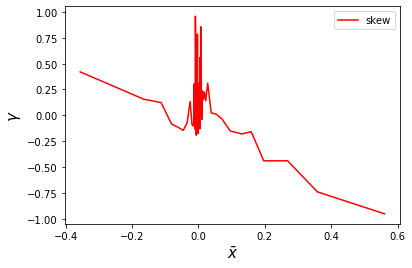

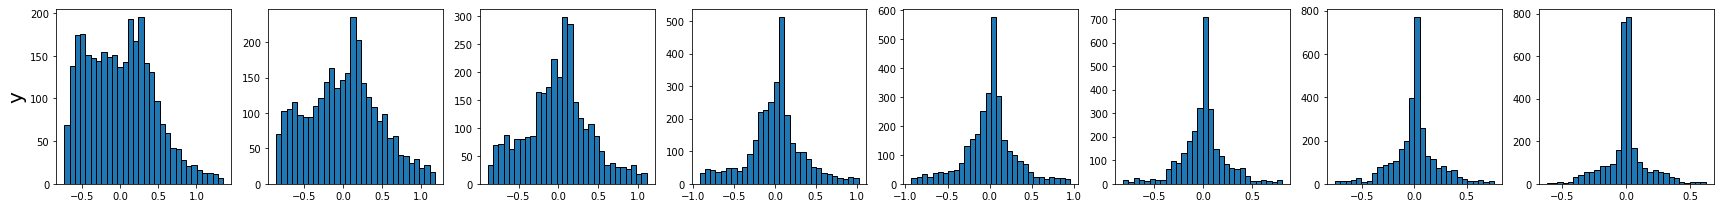

------------------------------------------------------------------------------------------------------------------


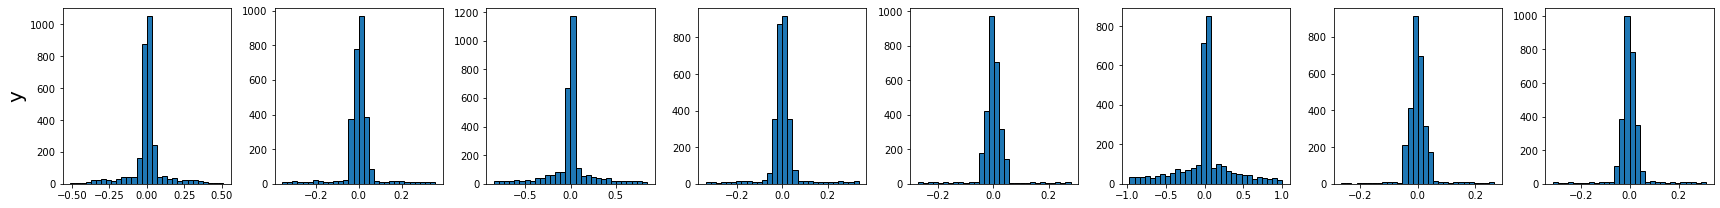

------------------------------------------------------------------------------------------------------------------


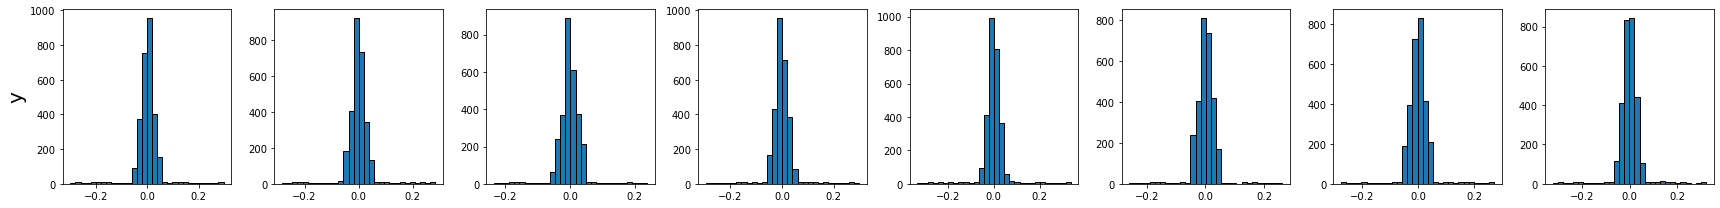

------------------------------------------------------------------------------------------------------------------


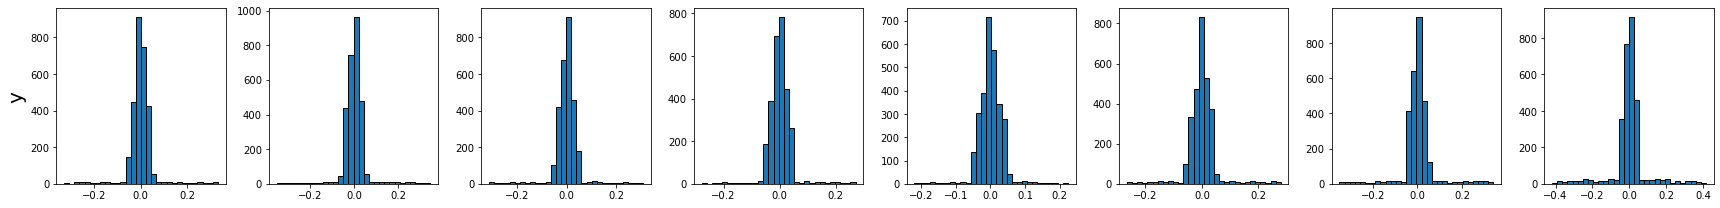

------------------------------------------------------------------------------------------------------------------


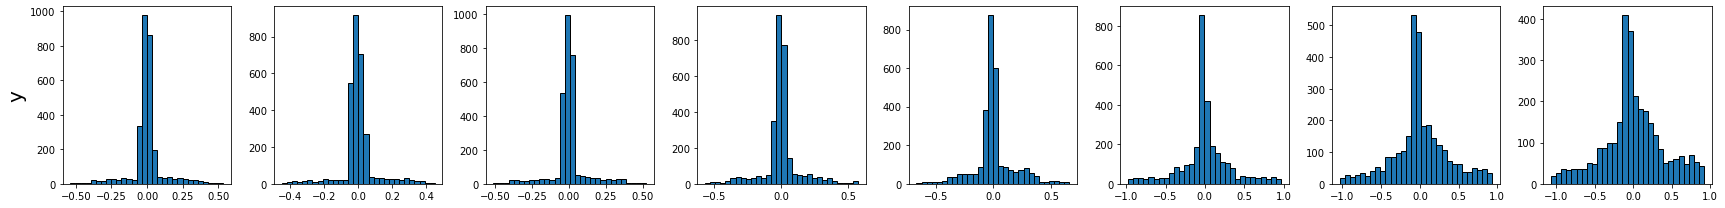

------------------------------------------------------------------------------------------------------------------


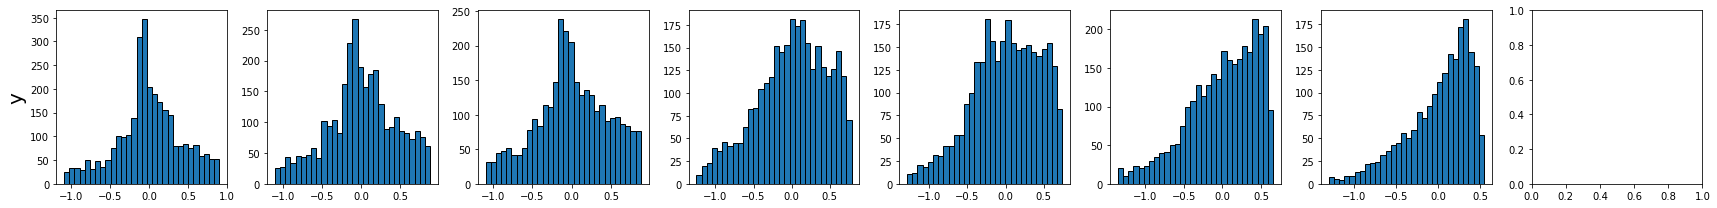

------------------------------------------------------------------------------------------------------------------


In [25]:
idx = 2
x = predicted[:,idx]
y =  injected[:,idx]
print('\n', '#'*80,'\n', 'feature n.', idx+1, ': ', names[idx].replace('$', ''), '\n', '#'*80, sep='')
xbins, ybins = Test(x,y, plot=True, bins_plot=True, sigma_tol=3, n=3000, project=True)


################################################################################
feature n.1: m_1
################################################################################


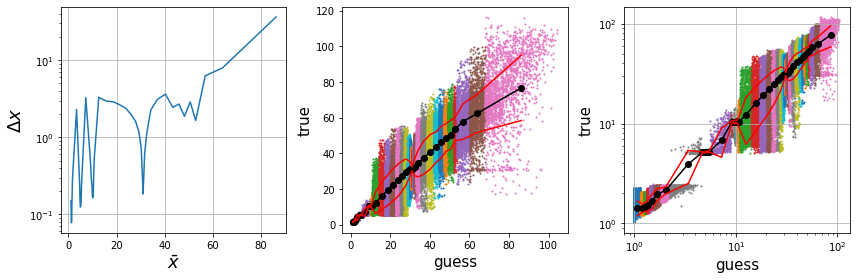

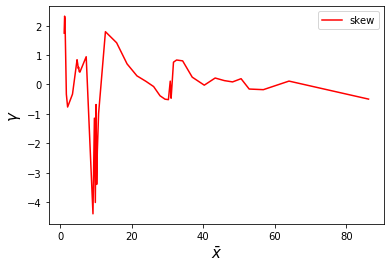

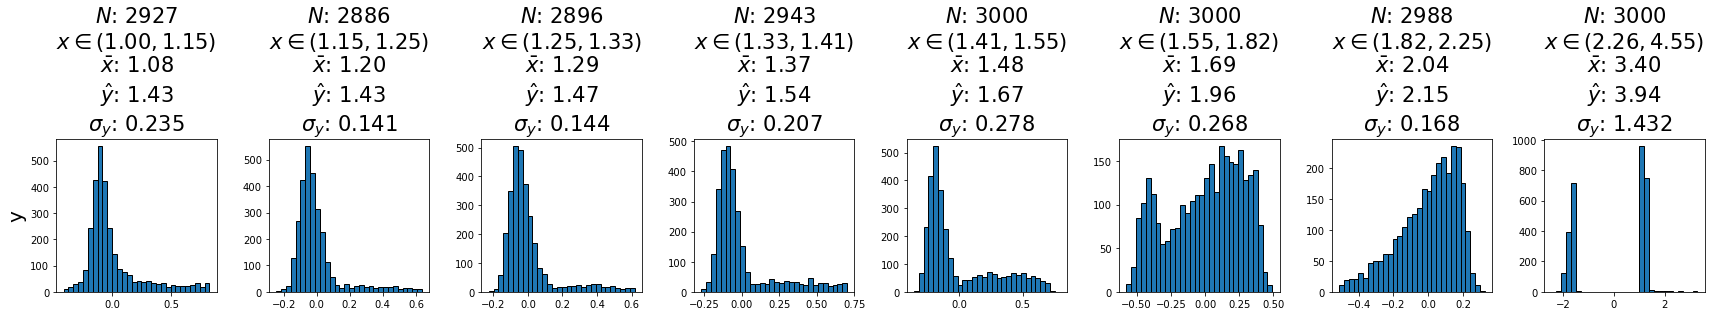

------------------------------------------------------------------------------------------------------------------


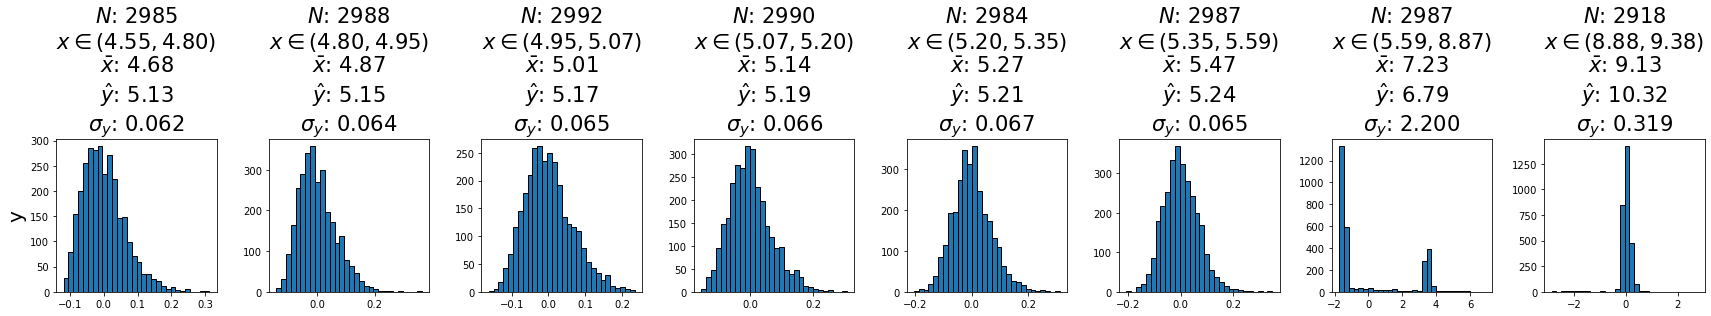

------------------------------------------------------------------------------------------------------------------


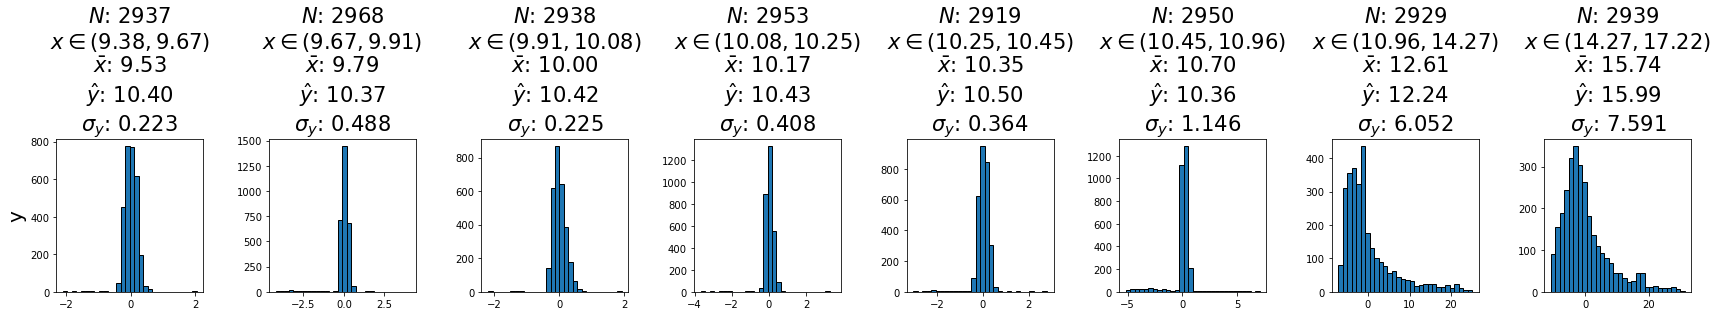

------------------------------------------------------------------------------------------------------------------


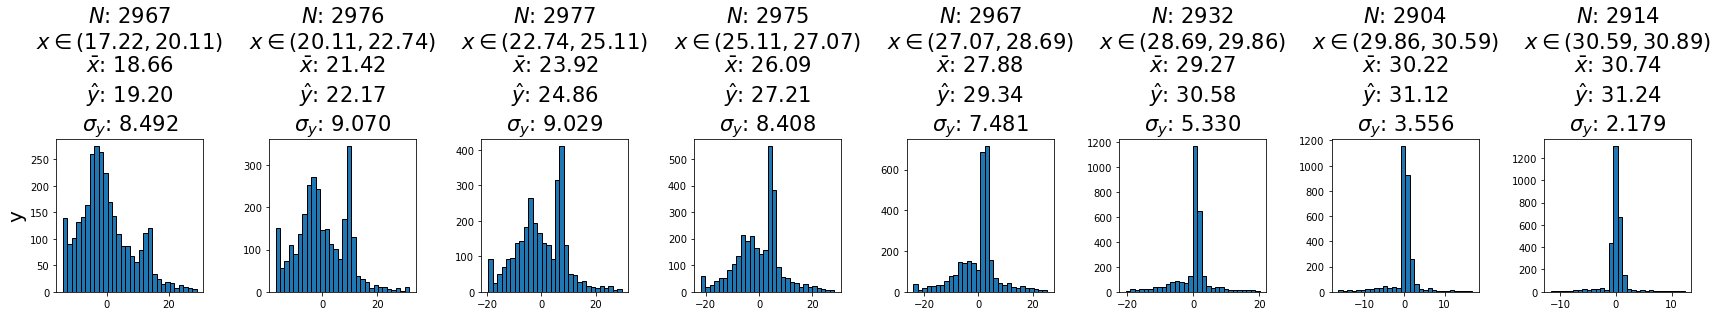

------------------------------------------------------------------------------------------------------------------


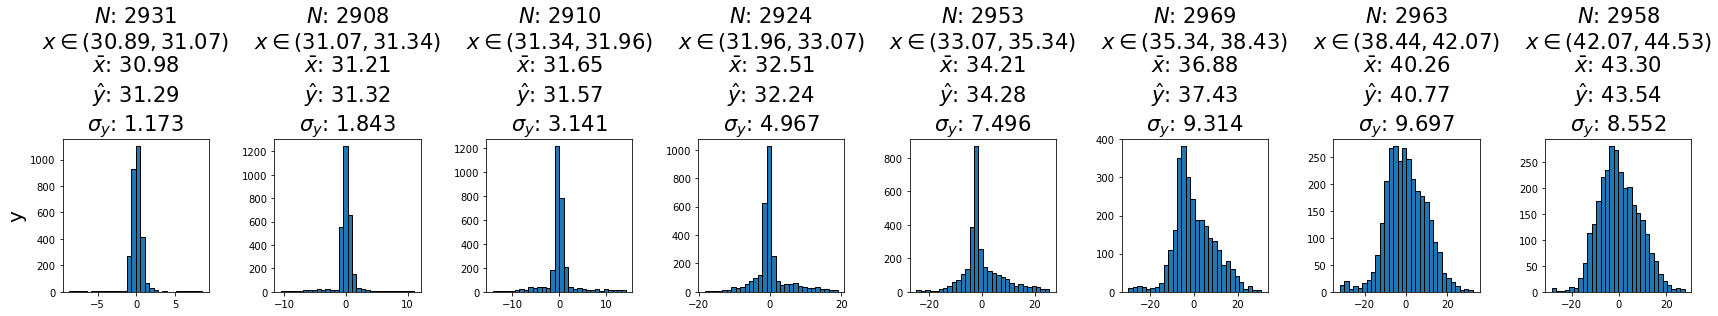

------------------------------------------------------------------------------------------------------------------


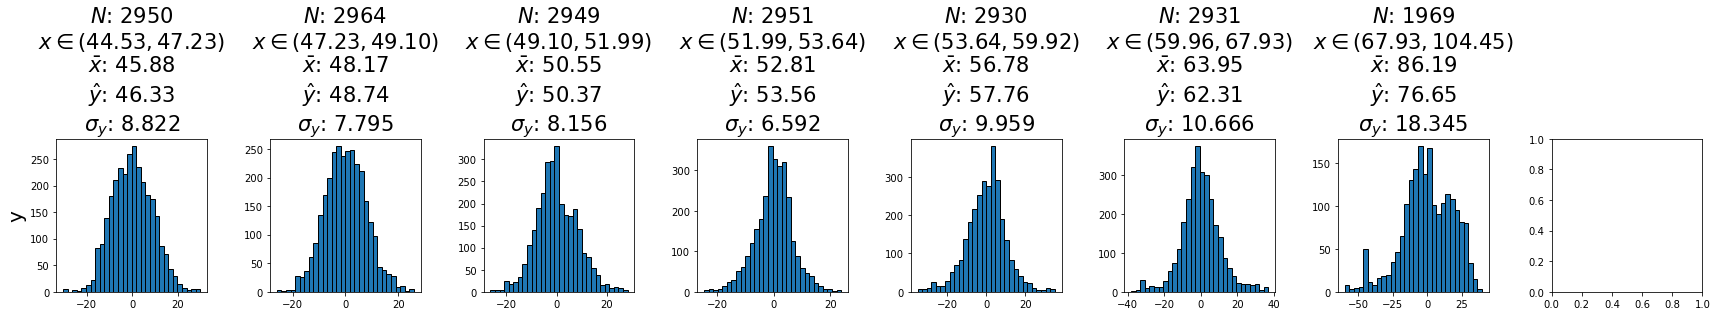

------------------------------------------------------------------------------------------------------------------


In [26]:
idx = 0
x = predicted[:,idx]
y =  injected[:,idx]
print('\n', '#'*80,'\n', 'feature n.', idx+1, ': ', names[idx].replace('$', ''), '\n', '#'*80, sep='')
xbins, ybins = Test(x,y, plot=True, bins_plot=True, sigma_tol=3, n=3000, project=False, print_ybins_info=True)

In [44]:
#test_prediction = NN.compute_prediction(NN.xtest, transform_output=True)
#cnn.write_result('cNN_prediction.csv', test_prediction, verbose=True)